# SIRD parameter learning using LM-BFGS with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameter $\theta$ is non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha = (\beta, \gamma) \in [0,1]^2$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones, eye, empty, append, diagflat, tril, triu
from numpy           import logical_and, where, allclose, full, clip, arctan, exp, pi, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from matplotlib.cm   import get_cmap
from scipy.interpolate   import CubicHermiteSpline
from scipy.sparse.linalg import LinearOperator
from numpy.polynomial.chebyshev import chebpts1

# Problem setup

In [4]:
# Total population
n = 200
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code
# Deceased rate
m = 0.01

## Generation of $\widehat \rho$

We are going to generate one choice for $\widehat\rho$ as the three curves that satisfy the initial conditions.

In [5]:
T  = 10                            # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [6]:
# Parameters for the shape of R and S
aᵣ = 2.0;    bᵣ = 3;    cᵣ = 0.6
aₛ = 6;       bₛ = 0.001;    cₛ = 0.5

Rₜ  = 2 * arctan(aᵣ * (Tₑ - bᵣ)) / pi              # Weighted arctan
Rₜ  = (Rₜ - Rₜ[0])/(1 - Rₜ[0])                       # Normalised curve in [0, 1]
Rₜ *= cᵣ * n                                       # Limit recovered to cᵣ * n

Sₜ  = (exp(-bₛ * Tₑ**aₛ) + (1-cₛ))/(2.0 - cₛ)        # Normalised super gaussian in [cₛ/(2-cₛ),1]
Sₜ *= n * (1 - f)                                  # Proportion of susceptible at time 0: Sₒ

In [7]:
Iₜ = n - Sₜ - Rₜ                                    # Infected is difference
if Iₜ.min() < 0:
    maximum(Iₜ, Iₜ[Iₜ > 0.0].min(), Iₜ);             # Ensure non negativity (might result in Sₜ + Iₜ + Rₜ > n)

In [8]:
print('Sₜ + Iₜ + Rₜ = n holds?', allclose(Sₜ + Iₜ + Rₜ, n))

Sₜ + Iₜ + Rₜ = n holds? True


Compute first derivative in time of desired state, just for interpolator:

In [9]:
dRₜ  = (2 * aᵣ) / ( pi * ( aᵣ**2 * (Tₑ - bᵣ)**2 + 1 ) )    # Weighted arctan
dRₜ /= 1 - Rₜ[0]                                            # Normalised curve in [0, 1]
dRₜ *= cᵣ * n                                              # Limit recovered to cᵣ * n

dSₜ  = -( aₛ * bₛ * (Tₑ)**(aₛ - 1.0) * exp(-bₛ * Tₑ**aₛ) )/(2.0 - cₛ)   # Normalised super gaussian in [cₛ/(2-cₛ),1]
dSₜ *= n * (1 - f)                                         # Proportion of susceptible at time 0: Sₒ Scotland

In [10]:
dIₜ = 0.0 - dSₜ - dRₜ                                       # Infected is difference
if ((n - Sₜ - Rₜ) < 0).any():
    dIₜ[n - Sₜ - Rₜ <= 0.0] = 0.0                           # Use a subgradient (might require continuity argument)

Assemble state:

In [11]:
ρ̂  = asarray([Sₜ, Iₜ, Rₜ])
dρ̂ = asarray([dSₜ, dIₜ, dRₜ])

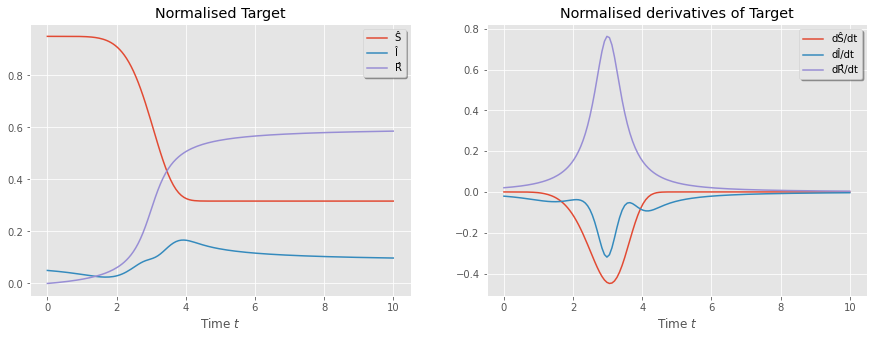

In [12]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, dρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dŜ/dt', 'dÎ/dt', 'dR̂/dt'], shadow=True)
plt.title('Normalised derivatives of Target')
plt.show()

In [13]:
# Give a random initial control
α = asarray([0.01,0.02])

In [14]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [15]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y

# Create an abstract interpolator for state
ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
ρ̄ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)

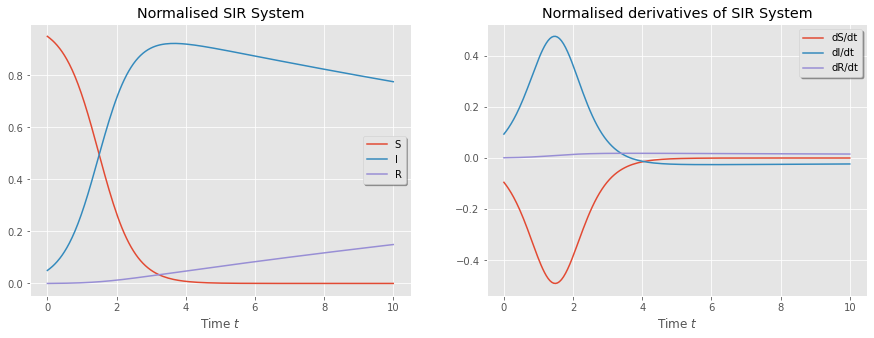

In [16]:
# Plot SIR curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, α[0], α[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [17]:
def Adjoint(t, z, β,γ,ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)    # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}_{\mathsf n}$:

In [18]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=True)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 416 function evaluations.


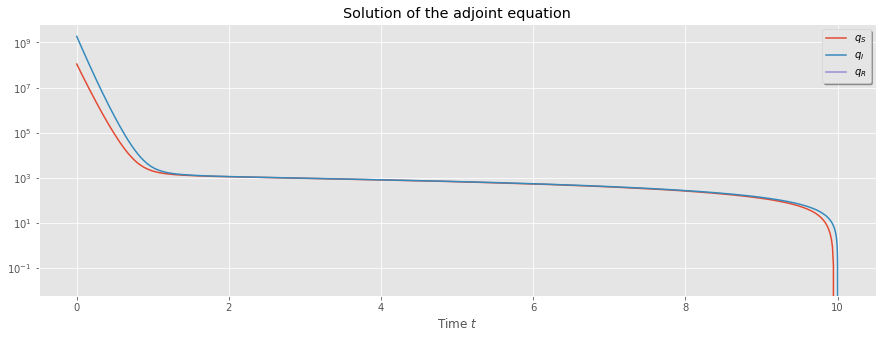

In [19]:
# Plot adjoint curves
plt.figure(figsize=(15,5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 ).
\end{align}

In [20]:
def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson((ρ-ρ̂)**2,Tₑ).sum() + θ * (α**2).sum())
# This one can be two times faster:
#def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson(((ρ-ρ̂)**2).sum(0),Tₑ) + θ * (α**2).sum())

In [21]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [22]:
θ = 0.1
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,1e+20) ))

As an example, the distance between ρ and ρ̂ is 25000000000152464.0000.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma
\end{align}

In [23]:
q = solₛ.y[:,::-1]

In [24]:
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ) + θ * α[0], simpson(ρ[1] * (q[2]-q[1]), Tₑ) + θ * α[1]])
display(df.tolist())

[207386783321.35318, -1181698193.521111]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [25]:
θ = 0.0

In [26]:
global ρ, q
ρ, q = empty((3, Tₑ.size), np.float64), empty((3, Tₑ.size), np.float64)

In [27]:
def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α,θ)
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], ρₜ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df  = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ), simpson(ρ[1] * (q[2]-q[1]), Tₑ)])
    df += (θ * α)
    df /= (n**2) if scaling else 1.0
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α,θ)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α,θ)
    f /= (n**2) if scaling else 1.0

    return f
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α,θ)
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρₐ, asarray(SIR(0,ρₐ,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], ρₜ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    q̂ = q_sol.y[:,::-1]

    # Compute derivative
    dF = asarray([simpson(ρₐ[0]*ρₐ[1] * (q̂[1]-q̂[0]), Tₑ), simpson(ρₐ[1] * (q̂[2]-q̂[1]), Tₑ)])
    dF += (θ * α)
    dF /= (n**2) if scaling else 1.0

    return f, dF

---

In [28]:
# Coarse evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.00,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a( asarray([β,γ]) ).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [29]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 1.8269310740815836; (β,γ): 0.02 0.314


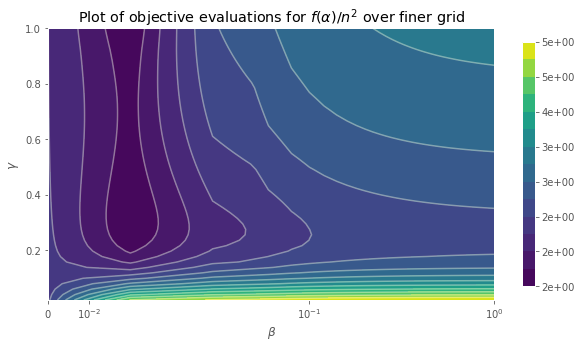

In [30]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('symlog', linthresh = 5e-2)
#plt.xscale('log')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

# Solving the optimisation problem

## Optimisation routine

We will use a trust region limited memory algorithm for optimising $f$. In this setting, we will write $x_k$ for the iterates $\alpha_k$.

Following the work of Yuan et al (2014), assuming 0 and $1$ as lower and upper bounds, respectively,
we introduce the quantity $x_k := \min\big\{\beta_k, c \|\nabla f(x_k)\|\big\} $, where $\beta_k$ and $c$ are positive constants such that $ 0 < \beta_k < \frac{1}{2} $, and define the strongly-active and inactive index sets by
\begin{align}
    A_k &:= \big\{ i \in \{1, \dots,n\}: \, x_{k,i} 
            \leq \xi_k \lor x_{k,i} \geq 1 -  \xi_k \big\},	
            \label{ec:active_set}
    \tag{1.a}
    \\
    I_k &:= \{1, \dots,n\} \setminus A_k = 
            \big\{ i \in \{1, \dots,n\}: \, \xi_k < x_{k,i} < 1 -  \xi_k \big\},	\label{ec:inactive_set}
    \tag{1.b}
\end{align}
respectively, where $x_{k,i}$ is the $i$-th element of $x_k$.
Now, suppose the current trust region radius is $\widehat\Delta >0$, with its maximum value $\Delta_{\max} > 0$, and let $\kappa > 0$. We can obtain a search direction at step $x_k$ as follows:

* **Projected gradient direction:** Compute
\begin{equation}\label{ec:proy_grad}
d^G_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{1 , \,x_k - \dfrac{\widehat\Delta}{\Delta_{\max}}  \kappa_k \nabla f(x_k) \right\} \right\} - x_k.
\tag{PG}
\end{equation}

* **Projected trust-region direction:** We look for a direction $d^{\text{tr}}_{*k} (\widehat\Delta)$ defined for each index of the sets $A_k$ and $I_k$, respectively.
We begin with $A_k$, for which we let $v_k^{A_k}$ be the subvector
\begin{equation}
    v_k^{A_k} :=
    \begin{cases}
        x_{k,i}     & \text{if } x_{k,i} \leq \xi_k,  \\
        1 - x_{k,i} & \text{if } x_{k,i} \geq 1 - \xi_{k}.
    \end{cases}
\end{equation}
Then we define the subvector
\begin{equation}
    d^{A_k}_{*k} (\widehat\Delta)  := \min \left\{ 1, \dfrac{\widehat\Delta}{\|v_k^{A_k}\|} \right\} v_k^{A_k}.
    \tag{SV}
\end{equation}
For the inactive set $I_k$ we solve a reduced trust-region subproblem. Here, let $B_k$ be partitioned into two submatrices $B_k^{A_k} $ and $B_k^{I_k} $, obtained by taking columns of $B_k$ indexed by $A_k$ and $I_k$, respectively. Let $ d^{I_k}_{*k} (\widehat\Delta) $ be a solution of the following TR–subproblem
\begin{equation} \label{ec:subvector_inactive}
\begin{aligned}
        \min \;\, & d^\top \Big[ \big(B_k^{I_k}\big)^\top \big( \nabla f(x_k) + B_k^{A_k} d^{A_k}_{*k}  \big) \Big] + \dfrac{1}{2} d^\top \big(B_k^{I_k}\big)^\top B_k^{I_k} d\\
\text{s.t. } & \|d\| \leq \widehat\Delta.
\end{aligned}
\tag{TR}
\end{equation}
The projected trust-region direction is then defined as
\begin{equation}
    d^{\text{tr}}_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{ 1, \, x_k + \begin{pmatrix} d^{A_k}_{*k} (\widehat\Delta) \\ d^{I_k}_{*k} (\widehat\Delta)  \end{pmatrix}\right\} \right\} - x_k.
\end{equation}
Since this direction may not be a descent direction for $f$ for far iterates, we use a convex combination with the gradient direction as follows.

* **Search direction:** Let
\begin{equation}
d_{* k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta),
	\end{equation}
	where $t_{*k}$  is a solution of the following one-dimensional problem
	\begin{equation}\label{ec:search_dir_one_dim}
		\min_{t \in [0,1]} f\big( x_k + t d_{*k}^G(\widehat\Delta) + (1- t) d^{\text{tr}}_{*k} (\widehat\Delta) \big).
        \tag{SD}
	\end{equation}

<div class="alert alert-block alert-warning">
Yuan, G., Wei, Z. & Zhang, M. An active-set projected trust region algorithm for box constrained optimization problems. J Syst Sci Complex 28, 1128–1147 (2015). https://doi.org/10.1007/s11424-014-2199-5
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Projected Trust-Region Algorithm with L-BFGS Update</h2>
<ol>
<li>Choose \(x_0 \) and a symmetric positive definite matrix \(H_0\). Let constants satisfy \(0 < \beta_0 < \frac{1}{2} \), \(c>0\), \(0 < \nu_1 < 1 < \nu_2\), \(0<\tau_1<\tau_2<1\), \(\upsilon \in (0,1)\), \(\omega \in \mathbb{R}\), \(\Delta_0 >0\), and \( \Delta_{\max} > \Delta_{\min} > 0\). Now set \(m \in \mathbb{N}\), \(k = 0\), and \(B_0 =H_0^{-1}\)
    </li>
    
<p><bf> \(\mathbf{Repeat}\)</bf></p>
    
<ol>
<li>
    Let \(\Delta_k := \min\big\{ \Delta_{\max}, \max\{\Delta_{\min}, \Delta_k\} \big\}\) and \(\widetilde\Delta = \Delta_k\).
</li>
    
<li> Determine index sets \(A_k\) and \(I_k\) by (1.a) and (1.b).
</li>
    
<li> Find \(d_{*k}^{\text{tr}} (\widetilde\Delta)\) by determining \(d_{*k}^{A_k} (\widetilde\Delta)\) and \(d_{*k}^{I_k} (\widetilde\Delta)\) as in (SV) and (TR).
</li>
    
<li> Set
    \[
        \kappa_k := \min\left\{ 1, \dfrac{\Delta_{\max}}{\big\| \nabla j(x_k) \big\|}, \dfrac{\omega}{\big\| \nabla j(x_k) \big\|} \right\}.
    \]
</li>


<li>Compute \( d_{*k}^G(\widetilde\Delta)\) and \(t_{*k}\) as in (PG) and (SD), respectively. Let
    \[
        d_{*k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta).
    \]
</li>
    
    
<li>Compute
    \[
        r_{*k} := \dfrac{ j(x_k + d_{*k}) - j(x_k)}{ \nabla j(x_k)^\top d_{*k} (\widehat\Delta) + \frac{1}{2} \, d_{*k} (\widehat\Delta)^\top B_k d_{*k} (\widehat\Delta)}
    \]
</li>
    
    
<li> \(\mathbf{If}\) \(j(x_k) - j \big(x_k + d_{*k} (\widehat\Delta) \big) \geq -\upsilon \nabla j (x_k)^\top d^G_{*k} (\widehat\Delta)\) and \(r_{*k} \geq \tau_1\) hold \(\mathbf{then}\)
</li>
    
<ol>
    <li> Let \(q_k := d_{*k}\), \(x_{k+1} := x_k + d_{*k}\), \(\beta_k = \widehat\Delta \), and
        \[
            \Delta_{k+1} :=
            \begin{cases}
                \widehat\Delta & \text{if } \tau_1 < r_{*k} < \tau_2,
                \\
                \nu_2 \widehat\Delta & \text{if } r_{*k} \geq \tau_2.
            \end{cases}
        \]
    </li>
    <li> Let \(\widehat m := \min\{k+1,m\}\). </li>
    <li> Update \(B_k\) with the \(n \times \widehat m\) matrices \(S_k\) and \(Y_k\) to get \(B_{k+1} \). </li>
    <li> Let \(k = k+1\) and return to step A. </li>
</ol>
    

    
<li> \(\mathbf{else}\) </li>
<ol>    
    <li>Let \(\widehat\Delta = \tau_1 \widehat\Delta\). </li>
<li> Return to step C.</li>
</ol>
</ol>
    
<p><bf> \(\mathbf{until}\, x_{k}\) satisfies some stopping criteria.</bf></p>
</div>

<div class="alert alert-block alert-warning">
<b>Limited memory</b>
</div>

The limited memory BFGS method approximates the inverse of the Hessian of a functional $j$ at iteration $k+1$, say $H_{k+1}$, without storing the dense matrices $H_k$ at each iteration. Instead, it stores $m$ correction pairs $ \{q_i, d_i\}_{i\in [k-1: k-m]} \subset\mathbb{R}^{n,2} $, where
\begin{equation}
    q_i := x_{i+1} - x_{i}
    \qquad\text{and}\qquad
    d_i := \nabla f(x_{i+1}) - \nabla f(x_{i}),
\end{equation}
that contain information related to the curvature of $f$. Byrd et al (1994) introduced a compact form to define the limited memory matrix $ B_k = H_k^{-1} $ in terms of the $ n\times m $ correction matrices
\begin{equation}
    S_k :=
        \begin{pmatrix}
            q_{k-m} & \cdots & q_{k-1}
        \end{pmatrix}
    \qquad\text{and}\qquad
    Y_k :=
        \begin{pmatrix}
            d_{k-m} & \cdots & d_{k-1}
        \end{pmatrix}.
\end{equation}
%
The main idea of the algorithm is that the matrix $S_k^\top Y_k$ can be written as the sum of the following three matrices:
\begin{equation}
    S_k^\top Y_k = L_k + D_k + R_k,
\end{equation}
where $L_k$ is strictly lower triangular, $D_k$ is diagonal, and $R_k$ is strictly upper triangular.

For $\theta > 0$, if the correction pairs satisfy $ q_i^\top d_i > 0 $, then the matrix obtained by updating $\theta I_n$ with the BFGS formula and the correction pairs after $k$-times can be written as
\begin{align}
    B_k &:= \theta I_n - W_k M_k W_k^\top,
\end{align}
where $W_k$ and $M_k$ are the block matrices given by
\begin{align}
W_k &:= \begin{pmatrix}	Y_k & \theta S_k \end{pmatrix},
\\
M_k &:= \begin{pmatrix}	-D_k & L_k^\top \\  L_k &  \theta S_k^\top S_k	\end{pmatrix}^{-1}.	\label{lbfgs-Bc}
\end{align}
Note that, as $M_k$ is a $2m\times 2m$ matrix, the cost of computing the inverse in the last formula is negligible. Hence, using the compact representation for $B_k$, various computations involving this matrix become inexpensive, as is the case of the product of $B_k$ times a vector.

One aspect of the BFGS method is that each update is positive definite. As the limited memory formula for $B_k$ can also be stated as
\begin{equation}
	B_k = V_k^\top H_k V_k + p_k q_k q_k^\top,
\end{equation}
with $ p_k := \big( q_k^\top d_k \big)^{-1}$ and $V_k :=  I_n - p_k d_k q_k^\top$. Thus, we can guarantee positive definiteness using Powell's method in which $d_k$ is redefined as
\begin{equation}
	d_k :=
	\begin{cases}
		d_k		& \text{if } q_k^\top d_k \geq 0.2 q_k^\top B_k d_k,
		\\
		\alpha_k d_k + (1-\alpha_k) B_k q_k & \text{otherwise},
	\end{cases}
\end{equation}
where $\alpha_k := \frac{0.8 q_k^\top B_k q_k}{q_k^\top B_k q_k - q_k^\top d_k}$. If the updated $q_k^\top d_k$ is too close to zero, to maintain numerical stability, the limited memory matrix is not updated.

<div class="alert alert-block alert-warning">
Richard H. Byrd, Jorge Nocedal, and Robert B. Schnabel. Representations of quasi-Newton matrices and their use in limited memory methods. Mathematical Programming, 63(1- 3):129–156, jan 1994.
</div>

To do:
* Crea un arreglo para los valores factibles de $\theta$ **(done)**
* Crea un loop que capture todo el proceso iterativo
* Almacena los valores de $\alpha_\theta$ que encuentre el algoritmo
* Almacena los mapas $\rho_\theta$
* Almacena la info de la última iteración de cada corrida
* Genera gráficos por separado mostrando cómo cambia cada curva

In [35]:
β, γ = α = rng(0).uniform(0,1,2)              # Initial point

In [36]:
dim = 2            # dimension of the parameter to optimise 

A Limited Memory BFGS method is used. The matrices will be constantly updated.

In [38]:
'''Functions needed for LM operations'''
def Limited():
    def B_eval(W,MI,dk):
        db  = dk.copy();         db *= θᵪ;        db -= W.dot(MI.dot(W.T.dot(dk)));            return db
    def BA_eval(W,MI,Uk,dUk):
        db = zeros(dim, dtype='float')
        db[Uk] = dUk;            db *= θᵪ;        db -= W.dot(MI.dot(W[Uk,:].T.dot(dUk)));     return db
    def BAT_eval(W,MI,Uk,dUk):
        db = dUk[Uk].copy();     db *= θᵪ;        db -= W[Uk,:].dot(MI.T.dot(W.T.dot(dUk)))
        return db
    def H_eval(WH,MH,dk):
        db  = dk.copy();         db /= θᵪ;        db += WH.dot(MH.dot(WH.T.dot(dk)));          return db
    def HA_eval(WH,MH,Uk,dUk):
        db = zeros(dim, dtype='float');   db[Uk] = dUk;    db /= θᵪ;    db += WH.dot(MH.dot(WH[Uk,:].T.dot(dUk)))
        return db
    def HAT_eval(WH,MH,Uk,dUk):
        db = dUk[Uk].copy();     db /= θᵪ;     db += WH[Uk,:].dot(MH.T.dot(WH.T.dot(dUk)));   return db
    return B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval

In [39]:
def LBFGS(S,Y,SY, θ):
    W   = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    M0  = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);    MM = append(M0,M1, axis=0)
    MI  = inv(MM)
    WH  = W.copy();       WH /= θ;    R = inv(triu(SY,k=0));            MH0 = append(O, -R, axis=1)
    MH1 = append(-R.T, R.T.dot((D + Y.T.dot(Y)/θ).dot(R)), axis=1);     MH  = append(MH0,MH1, axis=0)
    return MI, MH, W, WH
def LSR1(S,Y,SY, θ):
    W  = Y - θ*S;  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    MM = D + L + L.T - θ*S.T.dot(S);    MM *= -1
    while np.linalg.det(MM) == 0.0:
        θ *= 0.5
        W  = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        M0 = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);     MM = append(M0,M1, axis=0)
    MI = inv(MM)
    WH = W.copy();    WH /= θ;    R = triu(SY,k=0)
    MH = inv( R + R.T - D - (1.0/θ)*Y.T.dot(Y))
    return MI, MH, W, WH

We will run the problem for several regularisers:

In [383]:
#Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6), 5 * 10.0 ** arange(-7,5)) )
Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6)) )
Regularisers.sort()
print(Regularisers)

[0.e+00 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01
 1.e+02 1.e+03 1.e+04 1.e+05]


In [384]:
Stats  = None
States = dict()

for θ in Regularisers:
    # Run algorithm
    print('–'*20, '{0:.0e}'.format(θ), '–'*20, '\n\n')
    
    '''
    
        ********************************* AS-LM-BFGS algorithm *********************************
        
    '''
    Method = 'BFGS'
    
    
    '''Reserve memory'''
    cLM   = 1
    S     = append([1], zeros(dim-1)).reshape(dim,1);                        Y = S.copy()
    SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
    
    
    ''' Create structures to store information from iterates '''
    save_iter = True            # Do we store information for every iteration?
    if save_iter:
        ei_keys = ['it', 'obj', 'time', 'β', 'γ', 'df_β', 'df_γ', 't_k', 'norms']
        ei_norm = ['ℓ_1', 'ℓ_2', 'max', 'min']

        every_iter = {a:[] for a in ei_keys}
        every_iter['norms'] = {a:[] for a in ei_norm}


    save_critical = True        # Do we store information for every "critical" iteration?
    critical = 10               # An iteration is critical after some iterations
    if save_critical:
        ec_keys = ['it', 'obj', 'time', '|df|_2', '|df|_max']

        every_critical = {a:[] for a in ec_keys}
    
    
    ''' Initial point '''
    xₖ = asarray(α).copy()      # Be aware this α is different from αᵪ below
    
    
    ''' Algorithm parameters'''
    # All parameters involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.
    ''' Setting TR parameters '''
    αᵪ = [0.5, 2.0]                  # TR scaling factors  0 < αᵪ[0] < 1 < αᵪ[1]
    ρᵪ = [1e-5,0.75]                 # TR acceptance ratio (Success & Increase region)  0 < ρᵪ[0] < ρᵪ[1] < 1
    #ρᵪ = [1e-2,0.5]
    bᵪ = 1.0                         # Box upper bound
    σᵪ = 0.003                       # Armijo–Goldstein parameter for linesearch  0 < σᵪ < 1 (l/2L?) [0.00025]
    ηᵪ = 0.9                         # Normalisation scale for gradient directions  0 < ηᵪ < 1
    δᵪ = 0.99 * 0.5                  # Ambiguity threshold for active set estimation  δᵪ < ½ (ℓ-u)  [small>linear]
    cᵪ = 1.5                         # Gradient scaling factor for active set estimation  c > 0  [goes along pᵪ]
    pᵪ = 0.35                        # 0 < pᵪ < 1 [comment after Lemma 9.7 in 10.1007/978-1-4757-3279-5_9]
    mᵪ = 5                           # Memory size for LM
    θᵪ = 1.0                         # Initial weight for basic Hessian approximation
    Δᵪ = [1.0, 2.0, 1e-6, 1.0]       # TR radii: Δₖ, Δₘₐₓ, Δₘᵢₙ, Δ̂

    ''' Additional tolerances '''
    εᵪ_LM    = 1e-4                  # Tolerance of curvature sₖᵀyₖ > ε
    εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
    εᵪ_Ha    = 1e-11                 # Absolute Himmeblau criteria
    εᵪ_Hb    = 1e-13                 # Relative Himmeblau criteria
    
    
    ''' Initial iteration (xₒ, fₒ, dfₒ) '''
    fₖ, dfₖ  = obj_eval(xₖ)
    #print(fₖ)
    Obj_Res = [];              Obj_Res.append(fₖ.tolist())
    ''' Initial iteration counter and maximum number of iterations '''
    kᵪ      = 0;
    Max_It  = 100
    
    
    timed = 0.0              # Clock

    ''' Run algorithm for the given settings '''
    for kᵪ in range(Max_It):

        # Print header of table
        if kᵪ == 0:
            print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^11s}|{5:^11s}|'.format('#','β', 'γ', 'f(α)',
                                                                        'ᵣ‖∇f(α)‖2','ᵣ‖∇f(α)‖∞'), end='')
            print('{0:^5s}|{1:^5s}|{2:^8s}|{3:^11s}|{4:^11s}'.format('#Aₖ','#Iₖ','tₖ','ᵣ‖d‖2', 'Time'))

            print('–'*110)

            # Report initial iteration info
            if save_iter:
                every_iter['it'].append( kᵪ-1 )
                every_iter['obj'].append( fₖ )
                every_iter['time'].append( timed )
                every_iter['β'].append( xₖ[0] )
                every_iter['γ'].append( xₖ[1] )
                every_iter['df_β'].append( dfₖ[0] )
                every_iter['df_γ'].append( dfₖ[1] )
                every_iter['t_k'].append( 0.0 )
                # Store norms of gradient
                every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(2**0.5) )
                every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
                every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
                every_iter['norms']['min'].append( abs(dfₖ).min() )
            if kᵪ % critical == 0:
                every_critical['it'].append( kᵪ-1 )
                every_critical['obj'].append( fₖ )
                every_critical['time'].append( timed )
                every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
                every_critical['|df|_max'].append( norm(dfₖ,np.inf) )

            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|'.format(kᵪ-1, xₖ[0], xₖ[1], fₖ,
                                                                norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)) )

        # *************** #
        # Stationarity test
        if np.all(dfₖ[xₖ == 0.0] >= 0.0) & np.all(dfₖ[xₖ == 1] <= 0.0) & allclose(dfₖ[logical_and(xₖ>0.0, xₖ<1)], 0.0):
            print('Optimality reached.')
            break

        it_time = time.time()                                # Clock

        # *************** #
        # 1. TR radii update
        Δᵪ[0]  = min(Δᵪ[1], max(Δᵪ[2], Δᵪ[0]))               # Δₖ
        Δᵪ[-1] = Δᵪ[0]                                       # Δ̂

        # *************** #
        # 2. Active-set estimation: Determine the index sets Aₖ and Iₖ
        ξᵪ = min(δᵪ, cᵪ * norm(dfₖ) ** pᵪ )                  # Estimate of inactive region (12)
        Iₖ = where( (xₖ > ξᵪ) & (xₖ < bᵪ-ξᵪ) )[0]             # Inactive set (13)
        Aₖ = where( (xₖ <= ξᵪ) + (xₖ >= bᵪ-ξᵪ) )[0]            # Active set (13)

        # *************** #
        # 3. Trust-Region Subproblem

        # ––––––––– #
        # Limited memory matrix
        if Method == 'BFGS':
                     MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ)       # BFGS
        else:        MI, MH, W, WH = LSR1(S,Y,SY, θᵪ)        # SR1
        #
        B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval = Limited()

        # ––––––––– #
        # Gradient scaling
        γᵪ  = -min(1.0, Δᵪ[1]/norm(dfₖ), ηᵪ/norm(dfₖ))        # Scaling factor (24)
        #γᵪ = -min(1.0, Δᵪ[1]/norm(dfₖ))

        # ––––––––– #
        # Subvector of estimated active elements
        vₖ      = full(dim, np.nan)                           # Initialise
        Aˡᵪ, Aᵘᵪ = (xₖ <= ξᵪ), (xₖ >= bᵪ - ξᵪ)                 # Collect active indices
        vₖ[Aˡᵪ] = xₖ[Aˡᵪ];    vₖ[Aᵘᵪ] = bᵪ - xₖ[Aᵘᵪ]           # Lower and upper sides
        vAₖ     = vₖ[Aₖ]                                       # Extract info

        # ––––––––– #
        # Reserve memory for TR direction
        dTRₖ = ones(dim)


        # ––––––––– #
        # TR iteration
        kᵢₙₙₑᵣ = 0                                            # Inner iteration counter
        while 1 != 2:
            # ///// #
            # 3.a Projected Gradient Direction
            #wGₖ = max( (Δᵪ[-1]/Δᵪ[1]) * γᵪ, -1e-2)            # Scaling + prevention of the too large stepsizes
            wGₖ = (Δᵪ[-1]/Δᵪ[1]) * γᵪ                        # Just scaling 
            dGₖ = proj(xₖ + wGₖ * dfₖ) - xₖ

            # ///// #
            # Active direction [prevent empty division]
            wAₖ = min(1.0, Δᵪ[-1]/norm(vAₖ) ) if (Aₖ.size > 0 and norm(vAₖ) > 0 ) else 0.0
            dAₖ = wAₖ * vAₖ if (Aₖ.size > 0) else array([])

            # ///// #
            # 3.b Reduced TR subproblem in inactive set
            if Iₖ.size > 0:
                #dd      = dfₖ.copy()                             # Uncomment if the active info is not to be
                #dd[Ak] += dAk                                   # considered and comment c below.

                BBdₐ = BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Aₖ,dAₖ) + dfₖ)             # Linear part
                #BBdₐ = BAT_eval(W,MI,Iₖ, dfₖ)                                  # If Aₖ is not to be considered

                def mv(d):    return  BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Iₖ,d) )    # Product (Bₖᴵ)ᵀ(Bₖᴵ) d
                BB = LinearOperator((Iₖ.size,Iₖ.size), matvec=mv, rmatvec=mv)
                def fv(d):    return  BBdₐ.dot(d) + 0.5 * d.dot(BB(d))         # Subproblem objective
                def gv(d):    return  BBdₐ + BB(d)                             # Gradient of subproblem

                A_guess = HAT_eval(WH,MH,Iₖ, HA_eval(WH,MH,Iₖ, -BBdₐ))          # Unconstrained solution
                B_guess = where( (A_guess > Δᵪ[-1]) + (A_guess < -Δᵪ[-1]), dfₖ[Iₖ], A_guess)    # Constrained guess
                #B_guess = clip(A_guess, -Δᵪ[-1], Δᵪ[-1])                        # Alternatives
                #B_guess = clip(dfₖ[Iₖ], -Δᵪ[-1], Δᵪ[-1])

                InactiveSubProb = minimize(fv, x0 = B_guess, method='L-BFGS-B', jac = gv,
                                           bounds = Bounds(lb = -Δᵪ[-1], ub = Δᵪ[-1]), options = {'maxiter': 200})
                dIₖ = InactiveSubProb.x
            else:
                dIₖ = array([])

            # ///// #
            # Projected TR Direction [from LM and active sets]
            dTRₖ[Aₖ] = dAₖ;    dTRₖ[Iₖ] = dIₖ                   # TR direction (17)
            dTRₖ = proj(xₖ + dTRₖ) - xₖ                        # Projected direction (18)


            # *************** #
            # 4. Search direction
            # ///// #
            if allclose(dTRₖ, dGₖ) == True:        tₖ = 1.0
            else:
                # ** Optimize only knowing objective ** #
                #def a_fun(t):    return obj_eval_b( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )
                # ** Optimize with gradient information ** #
                def a_fun(t):
                    ob, der = obj_eval_d( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )        # All points are feasible
                    return ob, array( der.dot(dGₖ - dTRₖ) )

                # Optimise one dimensional convex combination between the obtained directions
                OneDimensionalCC = minimize(a_fun, x0 = [0.5], method = 'L-BFGS-B', jac = True, 
                                            bounds = Bounds(lb = 0.0, ub = 1.0), options={'maxiter': 10})

                # Retrieve optimisation information, warn if optimisation couldn't be completed but give "solution"
                #print((asarray([xₖ + (tt*dGₖ + (1-tt)*dTRₖ) for tt in linspace(0.0,1.0)]) < 0).any())
                if OneDimensionalCC.status != 0:
                    print('\033[1;31;47m * \x1b[0m', end = ' ')    
                tₖ = OneDimensionalCC.x.item()

            # ///// #
            # The final direction is the best linear combination of the projected gradient with the LM direction
            dₖ = tₖ * dGₖ + (1.0-tₖ) * dTRₖ


            # *************** #
            # 5. Test the Search Direction
            # ///// #
            Tfₖ, Tdfₖ = obj_eval(xₖ + dₖ)                      # Evaluate direction to be tested
            rₖ = (Tfₖ - fₖ)/( Tdfₖ.dot(dₖ) + 0.5 * dₖ.dot( B_eval(W,MI,dₖ) ) )        # TR reduction ratio

            # Check line search condition
            ArmijoGoldstein = (fₖ + σᵪ * dfₖ.dot(dGₖ) >= Tfₖ)
            # Test if reduction ratio is accepted
            AcceptReduction = (rₖ >= ρᵪ[0])

            # If both conditions are satisfied, then accept step and continue to the next iteration
            if AcceptReduction and ArmijoGoldstein:
                if kᵢₙₙₑᵣ > 0:     print('\x1b[0m')
                break
            else:
                # TR radius is decreased
                if kᵢₙₙₑᵣ == 0:    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
                # Update counter
                kᵢₙₙₑᵣ += 1
                # Decrease TR radius 
                Δᵪ[-1] *= αᵪ[0]
                # Print updated radius
                print('\033[0;33;2m {0:5.3e}'.format(Δᵪ[-1]), end = ' ')
                # ¡Stop! if TR radius is smaller than minimum radius Δₘᵢₙ
                if Δᵪ[-1] < Δᵪ[2]:
                    print('\x1b[0m \033[10;42;1m  TR-tol  \033[10;42;1m')
                    break

        # ––––––––– #
        # TR radius stopping criteria
        if Δᵪ[-1] < Δᵪ[2]:
            print('\033[10;42;1m  TR-min  \033[10;42;1m')
            break

        # ––––––––– #
        # Updating info
        sₖ  =   dₖ.copy()                                     # Point difference (xₖ + dₖ) - xₖ = dₖ
        yₖ  = -dfₖ.copy()                                     # Store f'(xₖ)
        xₖ += dₖ                                              # Store xₖ + dₖ

        # ––––––––– #
        # Himmeblau stopping criteria
        if abs(fₖ) > εᵪ_HCond:
            if abs(fₖ - Tfₖ)/fₖ < εᵪ_Hb:
                print('\033[10;42;1m  Himmeblau-b  \033[10;42;1m')
                fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                break
        else:
            if abs(fₖ - Tfₖ) < εᵪ_Ha:
                print('\033[10;42;1m  Himmeblau-a  \033[10;42;1m')
                fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                break

        # ––––––––– #
        # Updating info
        fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()                      # Update global objective and derivate
        yₖ += dfₖ                                             # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
        #δᵪ_ₖ  = Δᵪ[-1]                                       # Radius of the acceptable trial step [never used]

        # ––––––––– #
        # Test for TR expansion
        if rₖ >= ρᵪ[1]:
            Δᵪ[0] = αᵪ[1] * Δᵪ[-1]
        else:
            Δᵪ[0] = Δᵪ[-1]


        # ––––––––– #
        # Update of LM info
        ϕᵪ = [sₖ.dot(yₖ), sₖ.dot(B_eval(W,MI,sₖ))]

        # Powell correction
        if ϕᵪ[0] < 0.2 * ϕᵪ[1]:
            # print('\033[0;34;48m [P] \x1b[0m')
            əᵪ  = 0.8 * ϕᵪ[1]/(ϕᵪ[1] - ϕᵪ[0])
            yₖ *= əᵪ
            yₖ += (1.0 - əᵪ) * B_eval(W,MI,sₖ)

        # Add LM updates if curvature sₖᵀyₖ is not too small
        if ϕᵪ[0] > εᵪ_LM:
            # print('\033[5;34;46m [C] \x1b[0m')
            cLM = min(S.shape[1], mᵪ)            # Current LM size
            if cLM < mᵪ:                         # If size is small, add column with secant information
                S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
                cLM  += 1 
                SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
            else:                                # If size is too large, drop first column
                S = append(S[:,1:], sₖ[:,None], axis=1)
                Y = append(Y[:,1:], yₖ[:,None], axis=1)

            #print( norm(yₖ)/norm(sₖ) )           # This quantity can be of interest

        # If curvature is too small, we can reset the LM objects
        if ϕᵪ[1] < εᵪ_LM:
            # print('\033[7;34;48m [R] \x1b[0m')
            cLM   = 1
            S     = append([1], zeros(dim-1)).reshape(dim,1);    Y = S.copy()
            SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)


        # *************** #
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time

        # Report current status
        if save_iter:
            every_iter['it'].append( kᵪ )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['β'].append( xₖ[0] )
            every_iter['γ'].append( xₖ[1] )
            every_iter['df_β'].append( dfₖ[0] )
            every_iter['df_γ'].append( dfₖ[1] )
            every_iter['t_k'].append( tₖ )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
            every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
            every_iter['norms']['min'].append( abs(dfₖ).min() )
        if kᵪ % critical == 0:
            every_critical['it'].append( kᵪ )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
            every_critical['|df|_max'].append( norm(dfₖ,np.inf) )


        # Store objective [might not be needed anymore but it's handy]
        Obj_Res.append(fₖ.tolist())

        if kᵪ % critical == 0:
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1], fₖ,
                                                                norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)), end='')
            print('{0:^5d}|{1:^5d}|{2:^8.3g}|{3:^11.3e}|{4:^11.3g}'.format(Aₖ.size, 
                                                                           Iₖ.size,tₖ,norm(dₖ)/(dim**0.5), timed))


        if kᵪ == (Max_It - 1):
            print('\033[10;41;1m  Maxiter  \033[10;41;1m')

    # Measure final time
    end = time.time();    timed += end - it_time
    print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))
    print('\x1b[0m')
    
    


    # Recover dataframe from results
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)


    # Store info from last iterate
    Out_θ = df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():θ}).copy()
    Stats = pd.concat([Stats,Out_θ])
    States[θ] = ρ.copy()

–––––––––––––––––––– 0e+00 –––––––––––––––––––– 


  #  |     β     |     γ     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 6.370e-01 | 2.698e-01 | 2.596e+00 | 2.538e-01 | 3.572e-01 |
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
  0  | 6.358e-01 | 2.586e-01 | 2.593e+00 | 1.273e-01 | 1.760e-01 |  2  |  0  |   1    | 7.932e-03 |   2.63    
 TR-radius:  6.250e-02 
 TR-radius:  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  2.500e-01 
 TR-radius:  2.500e-01  1.250e-01 
 10  | 5.983e-01 | 2.504e-01 | 2.591e+00 | 3.114e-02 | 4.032e-02 |  2  |  0  |   1    | 3.710e-03 |   5.36    
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 20  | 5.449e-01 | 2.500e-01 | 2.588e+00 | 3.652e-02 | 5.111e-02 |  

 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
  0  | 6.358e-01 | 2.586e-01 | 2.593e+00 | 1.273e-01 | 1.760e-01 |  2  |  0  |   1    | 7.932e-03 |   2.93    
 TR-radius:  6.250e-02 
 TR-radius:  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  2.500e-01 
 TR-radius:  2.500e-01  1.250e-01 
 10  | 5.983e-01 | 2.504e-01 | 2.591e+00 | 3.114e-02 | 4.032e-02 |  2  |  0  |   1    | 3.710e-03 |   5.45    
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 20  | 5.449e-01 | 2.500e-01 | 2.588e+00 | 3.652e-02 | 5.111e-02 |  2  |  0  |   1    | 2.388e-03 |   9.72    
 TR-radius:  5.000e-01  *   2.500e-01  1.250e-01 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  6.250e-02  3.125e-02  1.562e-02  7.812e-03  3.906e-03  1.953e-03 
 30  | 4.949e-01 | 2.525e-01 | 2.586e+00 | 5.658e-02 | 5.794e-02 |  1  |  1  | 0.972  | 6.239e-04 |   14.8    


  #  |     β     |     γ     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 6.370e-01 | 2.698e-01 | 2.596e+00 | 2.538e-01 | 3.572e-01 |
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
  0  | 6.358e-01 | 2.586e-01 | 2.593e+00 | 1.273e-01 | 1.760e-01 |  2  |  0  |   1    | 7.932e-03 |   2.57    
 TR-radius:  6.250e-02 
 TR-radius:  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  2.500e-01 
 TR-radius:  2.500e-01  1.250e-01 
 10  | 5.983e-01 | 2.504e-01 | 2.591e+00 | 3.114e-02 | 4.032e-02 |  2  |  0  |   1    | 3.710e-03 |   5.09    
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 20  | 5.449e-01 | 2.500e-01 | 2.588e+00 | 3.652e-02 | 5.111e-02 |  2  |  0  |   1    | 2.388e-03 |   9.34    
 TR-radi

 TR-radius:  3.906e-03  1.953e-03  9.766e-04 
 TR-radius:  9.766e-04  4.883e-04  2.441e-04 
 TR-radius:  2.441e-04  1.221e-04  6.104e-05  3.052e-05  1.526e-05  7.629e-06  3.815e-06  1.907e-06 
 TR-radius:  1.907e-06  9.537e-07    TR-tol  
  TR-min  

Algorithm stopped after 20.9675 seconds and 69 iterations.

–––––––––––––––––––– 1e+00 –––––––––––––––––––– 


  #  |     β     |     γ     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 6.370e-01 | 2.698e-01 | 2.596e+00 | 2.538e-01 | 3.572e-01 |
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
  0  | 6.358e-01 | 2.586e-01 | 2.593e+00 | 1.270e-01 | 1.760e-01 |  2  |  0  |   1    | 7.933e-03 |    2.4    
 TR-radius:  6.250e-02 
 TR-radius:  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  2.500e-01 
 TR-radius:  2.500e-01  1.250e-01 
 10  | 5.988e-01 | 2.503e-01

 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
  0  | 6.358e-01 | 2.586e-01 | 2.593e+00 | 1.275e-01 | 1.762e-01 |  2  |  0  |   1    | 7.951e-03 |   1.84    
 TR-radius:  6.250e-02 
 TR-radius:  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 10  | 5.953e-01 | 2.490e-01 | 2.591e+00 | 3.035e-02 | 4.165e-02 |  2  |  0  |   1    | 2.413e-03 |   4.93    
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 20  | 5.357e-01 | 2.483e-01 | 2.588e+00 | 4.194e-02 | 5.272e-02 |  2  |  0  |   1    | 2.143e-03 |   8.53    
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  1.000e+00  5.000e-01  2.500e-01  1.250e-01  6.250e-02 
 30  | 4.409e-01 | 2.492e-01 | 2.582e+00 | 5.444e-02 | 7.542e-02 |  2  |  0  |   1    | 6.362e-03 |   11.7    
 TR-radius:  5.000e-01  2.500e-01  1.250e-01 
 TR-radius:  5.000e-01  2.50

 TR-radius:  2.500e-01  1.250e-01 
 TR-radius:  2.500e-01  1.250e-01 
 20  | 2.059e-01 | 2.513e-01 | 2.557e+00 | 2.918e-01 | 4.096e-01 |  2  |  0  |   1    | 1.640e-02 |   6.02    
 *   TR-radius:  5.000e-01  2.500e-01  1.250e-01  6.250e-02  3.125e-02 
 *   TR-radius:  6.250e-02  3.125e-02 
 TR-radius:  1.250e-01  *   6.250e-02  3.125e-02  *  
 TR-radius:  3.125e-02 
 TR-radius:  3.125e-02  1.562e-02 
 30  | 6.369e-03 | 6.277e-01 | 1.556e-01 | 2.011e-01 | 2.820e-01 |  2  |  0  | 0.0763 | 1.023e-02 |    7.7    
 TR-radius:  1.562e-02 
 TR-radius:  1.562e-02  7.812e-03 
 TR-radius:  7.812e-03  3.906e-03  1.953e-03  9.766e-04 
 TR-radius:  9.766e-04  4.883e-04  2.441e-04  1.221e-04  6.104e-05  3.052e-05  1.526e-05  7.629e-06  3.815e-06  1.907e-06  9.537e-07    TR-tol  
  TR-min  

Algorithm stopped after 8.3837 seconds and 35 iterations.

–––––––––––––––––––– 1e+05 –––––––––––––––––––– 


  #  |     β     |     γ     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |  

In [627]:
#CMap = get_cmap('Wistia')
CMap = get_cmap('YlGnBu')
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

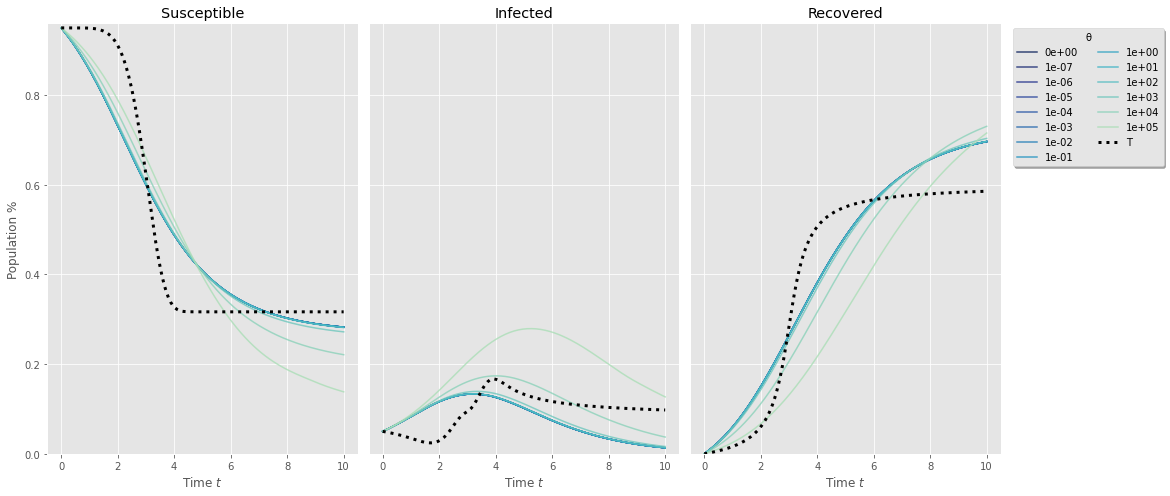

In [628]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
plt.savefig('Outputs/Regularisation – States – BFGS.pdf', bbox_inches='tight', pad_inches=0)

[]

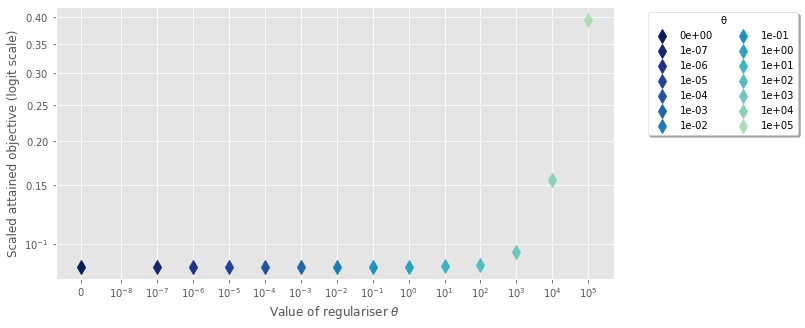

In [453]:
# Plot objective against θ
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for θ, fᵥ in Stats['obj'].iteritems():
    
    # Susceptible
    plt.plot(θ, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

Compute finer mesh:

In [41]:
θ = 0.0

In [42]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,1.0,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [457]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.09590670201662092; (β,γ): 0.006666666666666667 0.706


Plot of objective evaluations for f(α)/n² over finer grid


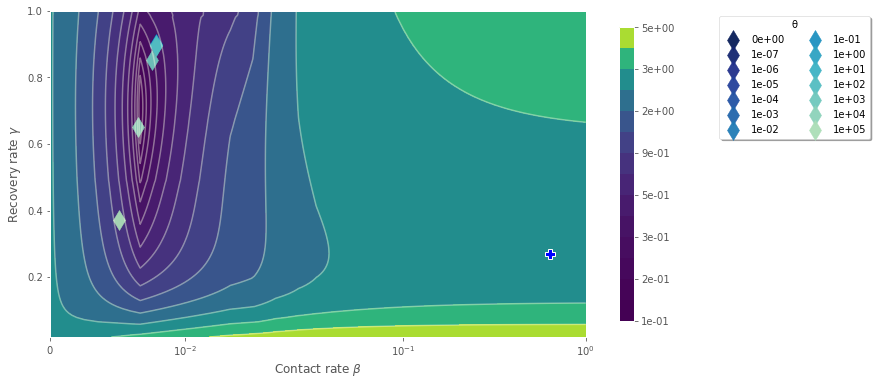

In [458]:
# Contour plot
print('Plot of objective evaluations for f(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )

# Approximate minimisers
k_row = colours_GD.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row],
         alpha = 0.95, marker='d', s = 200, label = '{0:.0e}'.format(θ))

    k_row -= 1
    
#plt.legend(handles=scatter.legend_elements()[0] )#, labels=Stats['β'].index.values)



'''
# Optimisation path PGD
ℓ_PGD = 1660
plt.plot( β_PGD[:-ℓ_PGD], γ_PGD[:-ℓ_PGD], c='xkcd:pale gold', markeredgecolor = 'gold',
         alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')
plt.plot( β_PGD[ ℓ_PGD:], γ_PGD[ ℓ_PGD:], c='gold', alpha=0.01, marker='3', linestyle = ':', markersize='4')

# Optimisation path FISTA
ℓ_FISTA = 20
plt.plot( β_FISTA[:ℓ_FISTA], γ_FISTA[:ℓ_FISTA], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.5, marker='.', linestyle = '-', markersize='7', label='FISTA')
plt.plot( β_FISTA[ ℓ_FISTA-1:], γ_FISTA[ ℓ_FISTA-1:], c='r', markeredgecolor = 'xkcd:rosa',
         alpha=0.5, marker='.',linestyle = '-',markersize='1')


# Optimisation path LM
plt.plot( β_LM, γ_LM, c='xkcd:turquoise blue', 
         markeredgecolor = "xkcd:robin's egg blue", markerfacecolor = '#FFD300', 
         alpha=0.5, marker='d', linestyle = '-.', markersize=4, label='LM-BFGS')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='*', color='white' )
'''


ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

---

Compute a fine gradient:

In [49]:
from scipy.interpolate import interp1d
from scipy.integrate import romberg

In [50]:
θ = 0.0

In [51]:
def ρ̄ₜ(t):
    # Parameters for the shape of R and S
    aᵣ = 2.0;    bᵣ = 3;    cᵣ = 0.6
    aₛ = 6;       bₛ = 0.001;    cₛ = 0.5

    Rₜ  = 2 * arctan(aᵣ * (t - bᵣ)) / pi               # Weighted arctan
    rₒ = 2 * arctan(aᵣ * (0.0 - bᵣ)) / pi
    Rₜ  = (Rₜ - rₒ)/(1 - rₒ)                            # Normalised curve in [0, 1]
    Rₜ *= cᵣ * n                                       # Limit recovered to cᵣ * n

    Sₜ  = (exp(-bₛ * t**aₛ) + (1-cₛ))/(2.0 - cₛ)         # Normalised super gaussian in [cₛ/(2-cₛ),1]
    Sₜ *= n * (1 - f)                                  # Proportion of susceptible at time 0: Sₒ 
    Iₜ = n - Sₜ - Rₜ                                    # Infected is difference
    if Iₜ.min() < 0:
        maximum(Iₜ, Iₜ[Iₜ > 0.0].min(), Iₜ);             # Ensure non negativity (might result in Sₜ + Iₜ + Rₜ > n)
    
    return asarray([Sₜ, Iₜ, Rₜ])

In [52]:
def obj_eval_der(α):                  # ** Eval f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    
    '''# Define integrand
    def f_integrand(t): return ((ρ̄(t) - ρₜ(t))**2).sum()
    #def f_integrand(t): return ((ρ̄ₜ(t) - ρₜ(t))**2).sum()
    
    
    # Integrate and add parameter norm
    f  = romberg(f_integrand, 0.0, T, show = False, vec_func=True, divmax = 20)
    f += (θ * (α**2).sum())
    f *= 0.5
    f /= (n**2) if scaling else 1.0'''
    
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], ρₜ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=True)
    q = q_sol.y[:,::-1]
    
    # Interpolate adjoint for handy evaluation of adjoint equation
    qᵢ = interp1d(Tₑ, q, axis=-1)
    
    # Evaluate dq/dt
    dq = np.zeros_like(ρ)
    for i in range(Tₑ.size):
        t = Tₑ[i]
        dq[:,i] = Adjoint(t, qᵢ(t), α[0], α[1], ρₜ)
        
    # Create a higher order accuracy interpolator for adjoint
    qₕ = CubicHermiteSpline(Tₑ, q, dq, axis=-1)
    
    # Define integrands
    def Df_integrand_β(t):
        ρ = ρₜ(t)
        q = qₕ(t)
        return ρ[0]*ρ[1] * (q[1]-q[0])
    def Df_integrand_γ(t):
        ρ = ρₜ(t)
        q = qₕ(t)
        return ρ[1] * (q[2]-q[1])

    # Compute derivative
    dβ = romberg(Df_integrand_β, 0.0, T, show = False, vec_func=True, divmax = 20)
    dγ = romberg(Df_integrand_γ, 0.0, T, show = False, vec_func=True, divmax = 20)
    
    df = asarray([dβ, dγ]).ravel()
    df += (θ * α)
    df /= (n**2) if scaling else 1.0
    
    '''# Compute derivative
    df  = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ), simpson(ρ[1] * (q[2]-q[1]), Tₑ)])
    df += (θ * α)
    df /= (n**2) if scaling else 1.0'''
    
    return df

In [53]:
obj_eval_der(asarray([0.05,0.95]))

array([9.13741551, 0.38729452])

In [656]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit_dβ, Misfit_dγ = zeros([2,nβ, nγ])
β_axis = linspace(0.0,1.0,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        df = obj_eval_der(asarray([β,γ]))
        Misfit_dβ[i,j] = df[0]
        Misfit_dγ[i,j] = df[1]
#i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
#M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

Plot of derivative evaluations for ∂ᵦf(α)/n² over finer grid


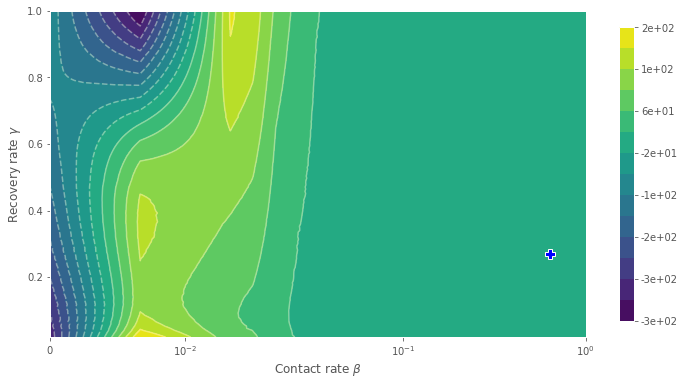

In [664]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵦf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_dβ).min(),(Misfit_dβ).max(),15)
#ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_dβ, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )



ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid


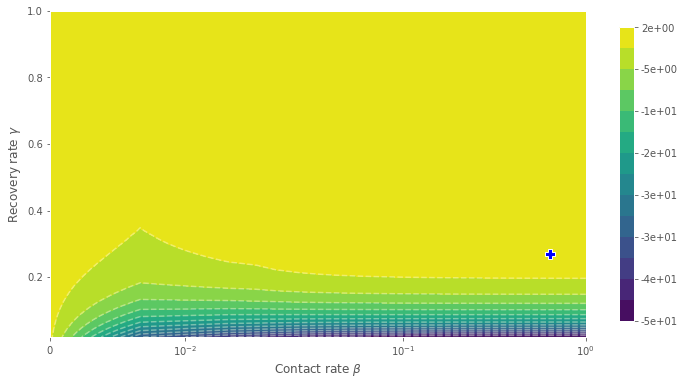

In [665]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_dγ).min(),(Misfit_dγ).max(),15)
#ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_dγ, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )



ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

In [666]:
Misfit_d = (Misfit_dβ**2 + Misfit_dγ**2)**0.5

Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid


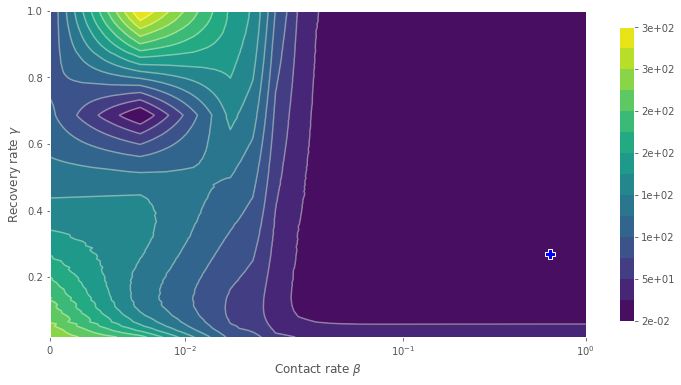

In [667]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_d).min(),(Misfit_d).max(),15)
#ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_d, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )



ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Get closer to minimisers:

In [54]:
θ = 0.0

In [55]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit_dβ, Misfit_dγ = zeros([2,nβ, nγ])
β_axis = linspace(0.0,0.01,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        df = obj_eval_der(asarray([β,γ]))
        Misfit_dβ[i,j] = df[0]
        Misfit_dγ[i,j] = df[1]
#i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
#M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [56]:
Misfit_d = (Misfit_dβ**2 + Misfit_dγ**2)**0.5

Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid


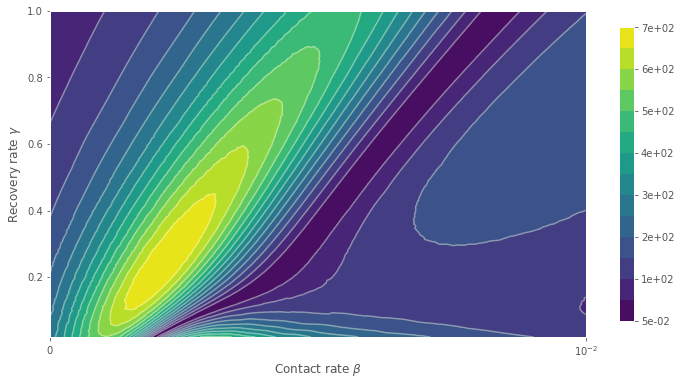

In [57]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_d).min(),(Misfit_d).max(),15)
#ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_d, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')




ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

---

In [385]:
Stats

,it,obj,time,β,γ,df_β,df_γ,t_k,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,68,0.08482674924854264,22.970191,0.007818,0.898486,0.012748,-0.001037,0.500000,0.006892,0.009044,0.012748,0.001037
1.000000e-07,70,0.08482573350797079,23.886513,0.007822,0.899223,0.000067,-0.000316,0.500000,0.000191,0.000228,0.000316,0.000067
1.000000e-06,72,0.08482594506112616,23.797171,0.007822,0.899012,0.122136,-0.001457,0.667422,0.061797,0.086370,0.122136,0.001457
1.000000e-05,70,0.08482611119705584,23.927479,0.007820,0.898940,-0.006376,-0.000397,0.816705,0.003387,0.004518,0.006376,0.000397
1.000000e-04,73,0.08482581804544104,23.451834,0.007822,0.899140,0.008570,-0.000787,0.500000,0.004679,0.006086,0.008570,0.000787
1.000000e-03,70,0.08482565830616348,25.187167,0.007822,0.899302,-0.012720,-0.000174,0.500000,0.006447,0.008995,0.012720,0.000174
1.000000e-02,68,0.08482646875719095,19.347795,0.007819,0.898750,0.006518,-0.000592,0.500000,0.003555,0.004628,0.006518,0.000592
1.000000e-01,68,0.08482730740782007,20.953025,0.007820,0.898807,-0.002555,-0.000519,0.500000,0.001537,0.001844,0.002555,0.000519
1.000000e+00,67,0.08483730896684447,22.024699,0.007816,0.898209,0.001802,-0.000809,0.500000,0.001305,0.001397,0.001802,0.000809
1.000000e+01,66,0.08492930480859419,19.382395,0.007812,0.897457,0.002005,-0.000712,0.500000,0.001359,0.001505,0.002005,0.000712


In [454]:
Stats.to_pickle('Outputs/Regularisation – LMBFGS - Final.pkl') # To read back use pd.read_pickle(file_name)

---

# Joint plots

In [25]:
Stats = pd.read_pickle('Outputs/Regularisation – LMBFGS - Every.pkl')
FISTA_final = pd.read_pickle('Outputs/Regularisation – FISTA - Every.pkl')
PGD_final   = pd.read_pickle('Outputs/Regularisation – PGD - Every.pkl')

In [26]:
FISTA_final.head()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,3128,0.084842,16.669936,0.007788,0.892901,0.059648,-0.003859,0.031754,0.042266,0.059648,0.003859
1.000000e-07,4672,0.084903,22.923078,0.007732,0.882813,0.110168,-0.008054,0.059111,0.078108,0.110168,0.008054
1.000000e-06,9999,0.088022,47.172081,0.007212,0.785478,2.156255,-0.068648,1.112452,1.525475,2.156255,0.068648
1.000000e-05,8061,0.087783,35.875959,0.007205,0.790228,-3.715067,-0.034291,1.874679,2.627061,3.715067,0.034291
1.000000e-04,5704,0.088325,29.744229,0.007177,0.780278,0.880495,-0.065258,0.472877,0.624311,0.880495,0.065258


In [27]:
PGD_final.head()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,78,0.132124,2.601850,0.005874,0.528139,1.480791,-0.359333,0.920062,1.077465,1.480791,0.359333
1.000000e-07,78,0.129332,2.581747,0.005914,0.536430,1.528241,-0.341562,0.934902,1.107291,1.528241,0.341562
1.000000e-06,72,0.129795,2.539128,0.005901,0.535036,0.269349,-0.338157,0.303753,0.305695,0.338157,0.269349
1.000000e-05,74,0.132180,2.523111,0.005870,0.527980,0.867274,-0.357242,0.612258,0.663245,0.867274,0.357242
1.000000e-04,75,0.131076,2.504316,0.005889,0.531202,1.607987,-0.353338,0.980663,1.164146,1.607987,0.353338


Select colours:

In [28]:
CMap = get_cmap('YlGnBu')
colours_BFGS = CMap(linspace(0.3,1,Stats.shape[0]))

CMap = get_cmap('YlOrBr')
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

CMap = get_cmap('RdPu')
colours_FISTA = CMap(linspace(0.3,1,Stats.shape[0]))

Attained objective:

[]

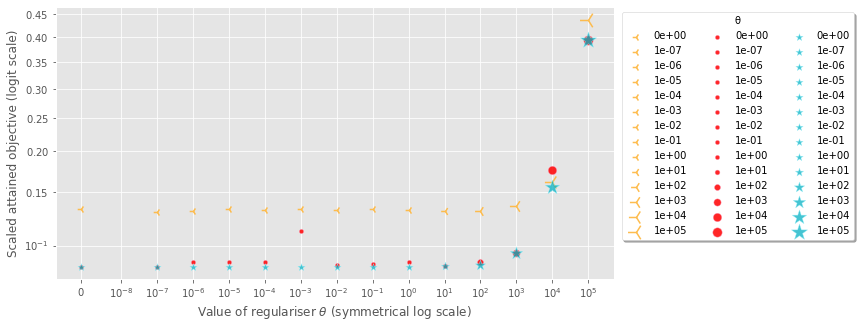

In [30]:
# Plot objective against θ
plt.figure(figsize=(10,5))
    
k = colours_GD.shape[0] - 1
for θ, fᵥ in PGD_final['obj'].iteritems():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = 'gold',#'xkcd:pale gold',#colours_GD[k], 
            #markeredgecolor = "xkcd:robin's egg blue",
             alpha=0.95, #1, 
             marker='3', linestyle = '', markersize = 2*np.log(θ+10),#10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1
    
k = colours_FISTA.shape[0] - 1
for θ, fᵥ in FISTA_final['obj'].iteritems():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = colours_FISTA[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='.', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1
    
k = colours_BFGS.shape[0] - 1
for θ, fᵥ in Stats['obj'].iteritems():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = colours_BFGS[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.44, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$ (symmetrical log scale)');    plt.ylabel('Scaled attained objective (logit scale)')
plt.savefig('Outputs/Regularisation – Objectives.pdf', bbox_inches='tight', pad_inches=0)
plt.plot()

Display minimisers:

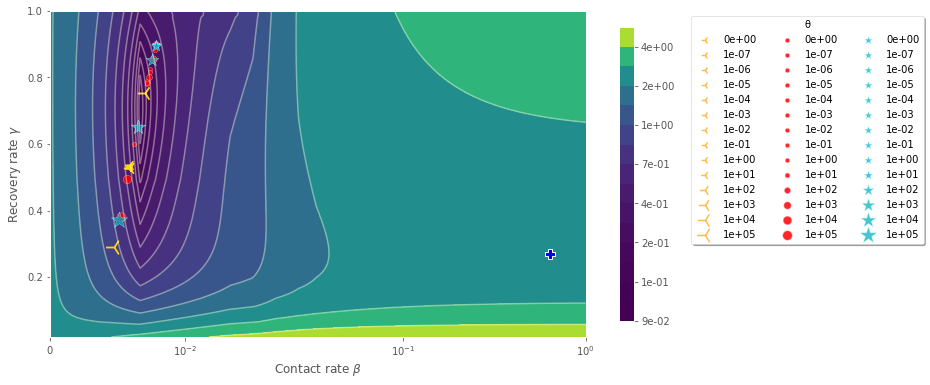

In [45]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = append( 0.086, np.logspace( np.log( Misfit[Misfit>0.0].min() ), np.log( Misfit.max() ), 
                num=15, endpoint=True, base=np.e) )
ℓ.sort()

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min

# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )



# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10))

    k_row -= 1

'''
# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='*', color='white' )'''





fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='θ')
plt.show()
fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

In [46]:
θ = 0.0

In [47]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,0.01,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

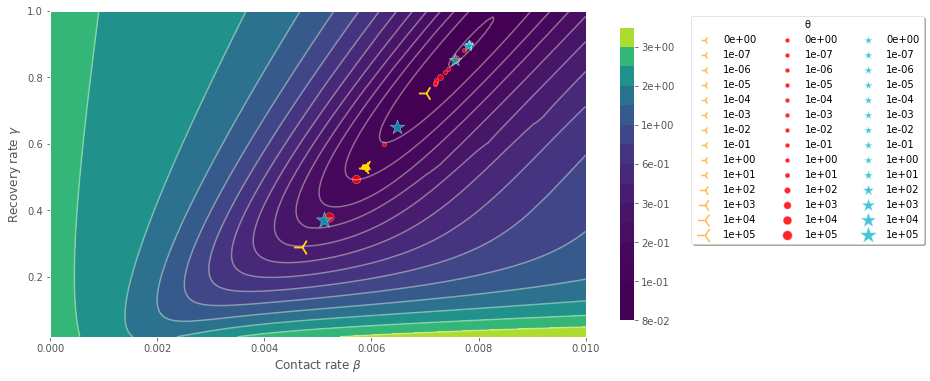

In [48]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = append( 0.086, np.logspace( np.log( Misfit[Misfit>0.0].min() ), np.log( Misfit.max() ), 
                num=15, endpoint=True, base=np.e) )
ℓ.sort()

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min



# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10))

    k_row -= 1

'''
# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='*', color='white' )'''





fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='θ')
plt.show()
fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Represent the same for gradient:

Plot of derivative evaluations for ‖∂f(α)‖/n² over finer grid


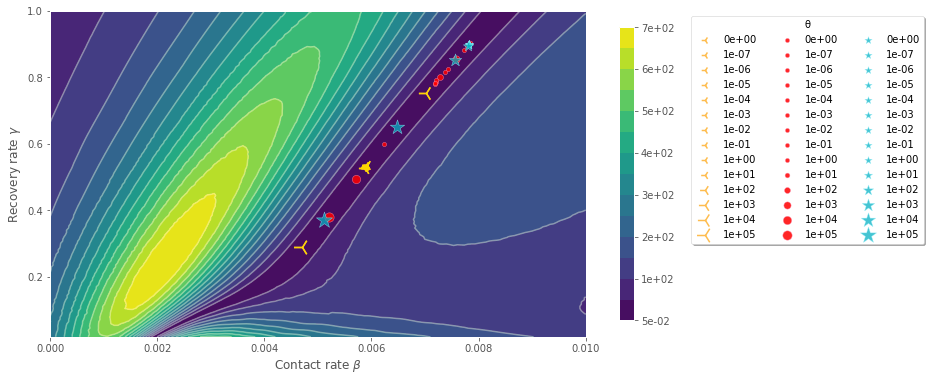

In [58]:
# Contour plot
print('Plot of derivative evaluations for ‖∂f(α)‖/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_d).min(),(Misfit_d).max(),15)
#ℓ = np.logspace( np.log( Misfit_d.min() ), np.log( Misfit_d.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_d, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10))

    k_row -= 1




ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='θ')
plt.show()
fig.savefig('Outputs/Regularisation – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

Plot of derivative evaluations for ∂ᵦf(α)/n² over finer grid


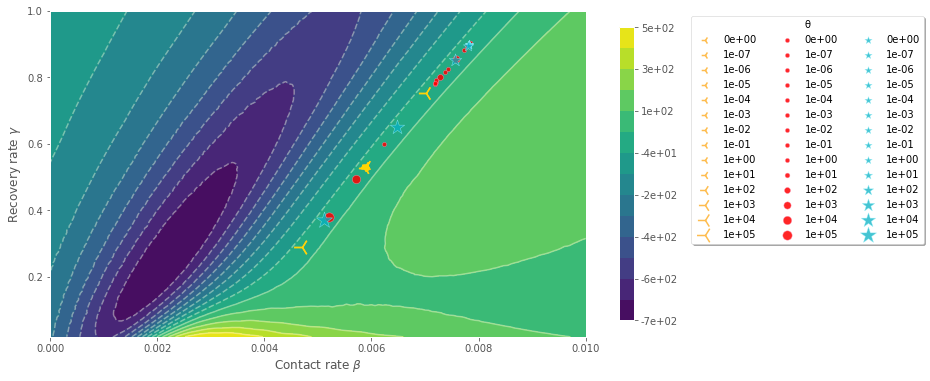

In [59]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵦf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_dβ).min(),(Misfit_dβ).max(),15)
#ℓ = np.logspace( np.log( Misfit_d.min() ), np.log( Misfit_d.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_dβ, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10))

    k_row -= 1




ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid


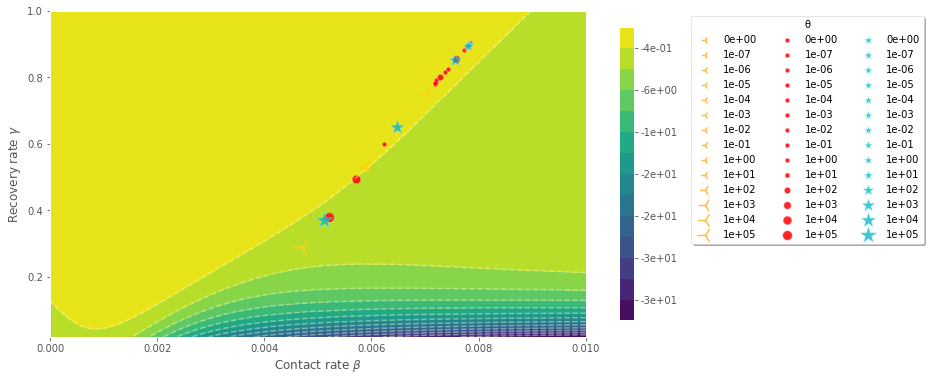

In [60]:
# Contour plot
print('Plot of derivative evaluations for ∂ᵧf(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit_dγ).min(),(Misfit_dγ).max(),15)
#ℓ = np.logspace( np.log( Misfit_d.min() ), np.log( Misfit_d.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit_dγ, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using FISTA
k_row = colours_FISTA.shape[0] - 1
for row in FISTA_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1

# Approximate minimisers using BFGS
k_row = colours_BFGS.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))

    k_row -= 1
    
    
# Approximate minimisers using PGD
k_row = colours_GD.shape[0] - 1
for row in PGD_final.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color='xkcd:pale gold', facecolor = 'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10))

    k_row -= 1




ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.64, 1), loc="upper right", shadow=True, ncol=3, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

---